<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/DL_Models/hybrid_01_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 378 (delta 72), reused 9 (delta 9), pack-reused 268 (from 2)
Receiving objects: 100% (378/378), 26.94 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [2]:
# Import libraries
import pandas as pd   # data processing
import numpy as np    # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, joblib, json
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np, joblib, json
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

In [3]:
# -----------------------
# Load your splits
# -----------------------
train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [4]:
!unzip -o dl_preprocessed.zip

Archive:  dl_preprocessed.zip
  inflating: dl_data_windows.npz     
  inflating: label_encoder.pkl       
  inflating: scaler.pkl              


In [5]:
# -----------------------
# Load preprocessed arrays
# -----------------------
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]

le = joblib.load("label_encoder.pkl")
classes = le.classes_

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


In [6]:
y_proba_ml = np.load("proba_ml.npy")
y_proba_dl = np.load("proba_dl.npy")


📊 Ensemble Classification Report:

                        precision    recall  f1-score   support

       aggressive-scan       0.92      0.67      0.77        18
         cryptojacking       1.00      1.00      1.00       165
            icmp-flood       0.75      0.69      0.72        13
    icmp-fragmentation       1.00      0.92      0.96        13
icmp-fragmentation_old       0.33      0.33      0.33         6
                  none       1.00      1.00      1.00       220
     os-fingerprinting       0.53      0.77      0.62        13
               os-scan       0.45      0.83      0.59         6
             port-scan       0.81      0.68      0.74        19
        push-ack-flood       1.00      1.00      1.00        12
      serice-detection       0.83      0.83      0.83         6
     service-detection       0.44      0.29      0.35        14
             syn-flood       1.00      1.00      1.00        13
           syn-stealth       0.59      0.59      0.59        17
   

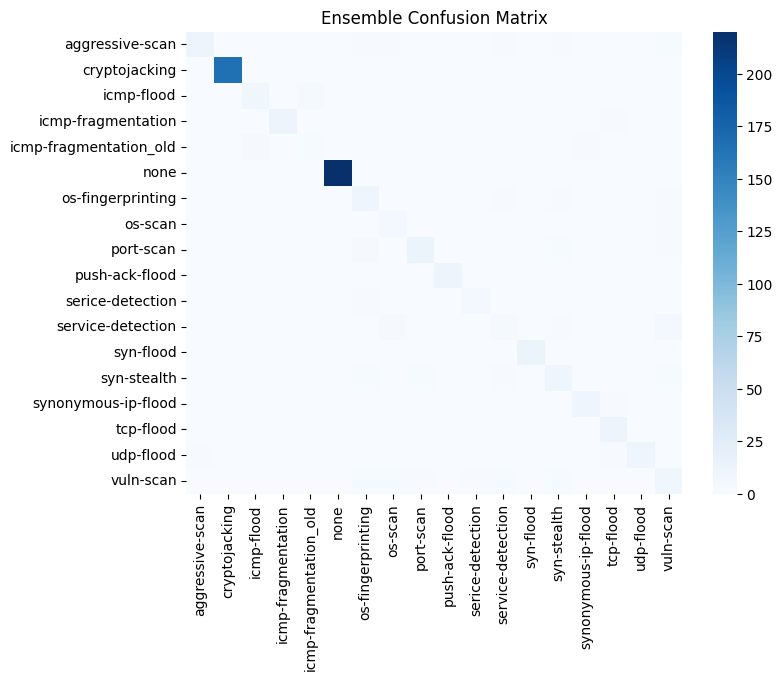

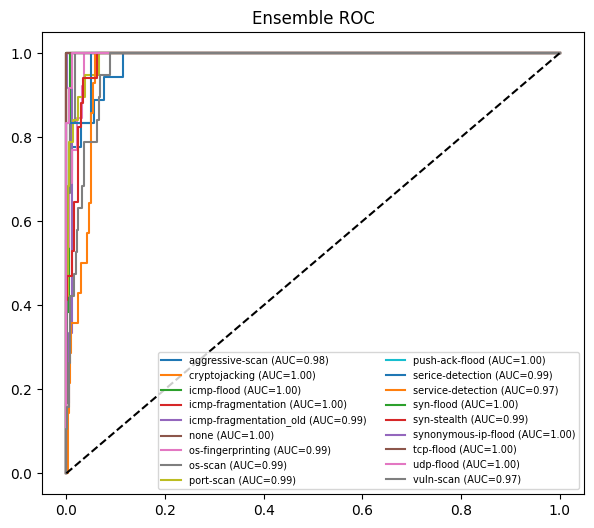

In [7]:
# --- Ensemble
w_ml, w_dl = 0.5, 0.5
proba_ens = w_ml * y_proba_ml + w_dl * y_proba_dl
y_pred_ens = proba_ens.argmax(axis=1)

acc = accuracy_score(y_test, y_pred_ens)
f1  = f1_score(y_test, y_pred_ens, average="macro")
print("\n📊 Ensemble Classification Report:\n")
print(classification_report(y_test, y_pred_ens, target_names=classes, zero_division=0))
print(f"✅ Accuracy={acc:.4f}, MacroF1={f1:.4f}")

# --- Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ens)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Ensemble Confusion Matrix"); plt.savefig("cm_ens.png", dpi=200); plt.show()

# --- ROC
y_true_bin = label_binarize(y_test, classes=np.arange(len(classes)))
plt.figure(figsize=(7,6))
for i, name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], proba_ens[:, i])
    auc = roc_auc_score(y_true_bin[:, i], proba_ens[:, i])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'k--'); plt.legend(fontsize=7, ncol=2)
plt.title("Ensemble ROC"); plt.savefig("roc_ens.png", dpi=200); plt.show()

# --- Save
with open("results_ensemble.json","w") as f:
    json.dump({"accuracy": float(acc), "macro_f1": float(f1),
               "report": classification_report(y_test, y_pred_ens, target_names=classes, zero_division=0),
               "confusion_matrix": cm.tolist()}, f, indent=2)